In [1]:
cd /content/drive/My Drive/Colab Notebooks/MaskRCNN_brain_mri

/content/drive/My Drive/Colab Notebooks/MaskRCNN_brain_mri


In [2]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-mqho3h5s
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-mqho3h5s
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=266458 sha256=926cd8a13c5b5d3c19c39694a21255acdccaff031383e08d9c47f167490d59e6
  Stored in directory: /tmp/pip-ephem-wheel-cache-wiztqc93/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0.1
    Uninstalling pycocotools-2.0.1:
      Successfully uninstalled pycocotools-2.0.1


In [3]:
import re
import numpy as np
import cv2
import torch
import torch.utils.data as data
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

def show_image(img):
  plt.imshow(img)
  plt.show()

In [4]:
import os.path as osp
from dataloader import make_datapath_list, BrainDataset, get_transform

rootpath = osp.abspath("")
makepath = make_datapath_list(rootpath)
test_img_list, test_anno_list = makepath.get_list("test")

In [5]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2
model = get_instance_segmentation_model(num_classes)

net_weights = torch.load('/content/drive/My Drive/Colab Notebooks/MaskRCNN_brain_mri/weights/maskrcnn_resnet50_fpn_15.pth',
                         map_location={'cuda:0': 'cpu'})
model.load_state_dict(net_weights)
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): 

In [7]:
dataset = BrainDataset(test_img_list, test_anno_list, get_transform(train=False))

In [8]:
class show_image_brain():
  def __init__(self, dataset, test_img_list, test_anno_list, model, device):
    self.dataset = dataset
    self.test_img_list = test_img_list
    self.test_anno_list = test_anno_list
    self.model = model
    self.device = device

  def make_result_img(self, index):
    img, _ = self.dataset[index]
    # put the model in evaluation mode
    self.model.eval()
    with torch.no_grad():
        prediction = model([img.to(self.device)])

    img_path = self.test_img_list[index]
    anno_path = self.test_anno_list[index]
    show_img = cv2.imread(img_path)
    anno_img = cv2.imread(anno_path, 0)

    anno_mask = show_img.copy()
    anno_mask[np.where(anno_img!=0)] = np.array([255, 255, 0])

    threshlod = 0.6
    pred_mask = show_img.copy()
    if len(prediction[0]['scores']) != 0:
      for i in range(len(prediction[0]['scores'])):
        score = prediction[0]['scores'][i].cpu().numpy()
        if score >= threshlod:
          pred = prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy()
          pred_mask[np.where(pred>=50)] = np.array([0,255,255])

    result_img = cv2.addWeighted(show_img, 0.2, anno_mask, 0.8, 0)
    result_img = cv2.addWeighted(result_img, 0.6, pred_mask, 0.4, 0)

    return result_img

/usr/local/lib/python3.6/dist-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


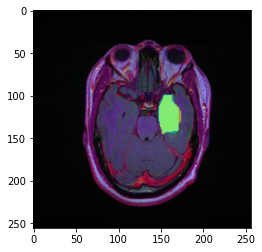

In [9]:
show_image_class = show_image_brain(dataset, test_img_list, test_anno_list, model, device)
result_img = show_image_class.make_result_img(20)
show_image(result_img)

In [11]:
for i, img_path in enumerate(test_img_list):
  save_path = img_path.split('kaggle_3m/')[-1]
  save_path = "result_image/" + re.split("[/.]", save_path)[-2] + '.png'
  print(save_path)
  result_img = show_image_class.make_result_img(i)
  cv2.imwrite(save_path, result_img)

result_image/TCGA_HT_7881_19981015_1.png
result_image/TCGA_HT_7881_19981015_10.png
result_image/TCGA_HT_7881_19981015_11.png
result_image/TCGA_HT_7881_19981015_12.png
result_image/TCGA_HT_7881_19981015_13.png
result_image/TCGA_HT_7881_19981015_14.png
result_image/TCGA_HT_7881_19981015_15.png
result_image/TCGA_HT_7881_19981015_16.png
result_image/TCGA_HT_7881_19981015_17.png
result_image/TCGA_HT_7881_19981015_18.png
result_image/TCGA_HT_7881_19981015_19.png
result_image/TCGA_HT_7881_19981015_2.png
result_image/TCGA_HT_7881_19981015_20.png
result_image/TCGA_HT_7881_19981015_21.png
result_image/TCGA_HT_7881_19981015_22.png
result_image/TCGA_HT_7881_19981015_23.png
result_image/TCGA_HT_7881_19981015_24.png
result_image/TCGA_HT_7881_19981015_25.png
result_image/TCGA_HT_7881_19981015_26.png
result_image/TCGA_HT_7881_19981015_27.png
result_image/TCGA_HT_7881_19981015_28.png
result_image/TCGA_HT_7881_19981015_29.png
result_image/TCGA_HT_7881_19981015_3.png
result_image/TCGA_HT_7881_19981015_30